In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [4]:

# 1. Chargement et préparation
df = pd.read_csv("C:/Users/alexi/Downloads/Copie de ActorsAIIren2025 - ActorsAIIren2025.csv")
cols = ['Description de la proposition de valeur : produits et de services.', 
        'Business model (sources de revenus)', 
        'Description des segments de marché servis.']
df['ADN'] = df[cols].fillna('').agg(' '.join, axis=1)

# 2. Mots vides et Vectorisation
french_stop_words = ['le','la','il','elle','elles','ils','les','de','du','des','un','une','et','en','pour','sur','qui','que','ia','IA','intelligence','artificielle']
bruit_ia = ['solutions','services','entreprise','entreprises','donnees','plateforme','aide','permet','secteur']

vectorizer = TfidfVectorizer(
    stop_words=french_stop_words + bruit_ia, 
    max_df=0.5, 
    ngram_range=(1, 2),
    min_df=1
)
X = vectorizer.fit_transform(df['ADN'])

# 3. Clustering plus fin (7 clusters)
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=15)
df['Cluster'] = kmeans.fit_predict(X)

# 4. DICTIONNAIRE THÉMATIQUE ENRICHI
themes = {
    "Fondations GenAI (LLM/API)": ["api", "llm", "langage", "générative", "modèles", "open source", "gpt", "tokens", "transformer", "prompt"],
    "Optimisation Sales & Marketing": ["crm", "vente", "marketing", "client", "sales", "revenus",  "conversion", "pricing", "forecast", "emailing", "automation"],
    "Hardware & Infrastructure": ["gpu", "puces", "hardware", "nvidia", "calcul", "semiconducteurs", "infrastructure", "compute","infrastructure", "cloud"],
    "Santé & BioTech": ["santé", "médical", "biotech", "patient", "diagnostic", "pharma", "biologique", "essais cliniques"],
    "Sécurité & Défense": ["défense", "sécurité", "militaire", "cyber", "surveillance", "souveraineté", "attaque",  "détection", "cyberattaque", "espionnage"],
    "Robotique & Mobilité": ["autonome", "conduite", "robotique", "véhicule", "capteurs", "industrielle", "drones"],
    "Finance & Analyse de risque": ["finance", "banque", "trading", "risque", "fraude", "investissement", "assurance", "scoring", "marchés" ],
    "Création & Médias": ["vidéo", "image", "audio", "créatif", "génération image", "montage", "contenu", "design"]}

# 5. Fonction de nommage automatique
def auto_label(cluster_id, model, terms):
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    top_words = [terms[ind] for ind in order_centroids[cluster_id, :25]] # On regarde plus large (25 mots)
    
    scores = {theme: 0 for theme in themes}
    for word in top_words:
        for theme, keywords in themes.items():
            if any(k in word for k in keywords):
                scores[theme] += 1
    
    # Trouver le gagnant
    gagnant = max(scores, key=scores.get)
    return gagnant if scores[gagnant] > 0 else f"Niche Spécifique {cluster_id}"

# 6. Application et Affichage
terms = vectorizer.get_feature_names_out()
df['Profil_Type'] = df['Cluster'].apply(lambda c: auto_label(c, kmeans, terms))

print(f"--- ANALYSE SUR {n_clusters} CLUSTERS ---")
for profil in df['Profil_Type'].unique():
    nb = len(df[df['Profil_Type'] == profil])
    exemples = df[df['Profil_Type'] == profil]["Nom de l'entreprise étudiée"].iloc[:32].tolist()
    print(f"\nProfil : {profil} ({nb} entreprises)")
    print(f"Exemples : {', '.join(exemples)}")

--- ANALYSE SUR 7 CLUSTERS ---

Profil : Optimisation Sales & Marketing (21 entreprises)
Exemples : Frame AI, UiPath, Dust, Blackrock, Lovable, Adobe Inc., Zaion, Shift Technology, K Health, Boston Dynamics, Grammarly, Speechmatics, CrowdStrike, Climate.ai, Notion, Sierra, SopraSteria, GitHub, Elicit IA, Synthesia, SAP

Profil : Hardware & Infrastructure (27 entreprises)
Exemples : iFlytek, Redpill, Anduril, Lambda, Baijiayun Group, SentinelOne, Palantir, Anthropic, Elevenlabs, IBM cloud, Apple Inc., Microsoft, CoreWeave, Nvidia, Azure (Microsoft), Oracle Corporation, Alibaba Cloud, Dynatrace, Innodura, Tencent Cloud, Microsoft Research en partenariat avec Xbox Game Studios, Fireflies, Yitu Technology (Shanghai Yitu Network Technology Co., Ltd.), Amotiv Limited, AssemblyAI, Google Cloud, AMD

Profil : Fondations GenAI (LLM/API) (27 entreprises)
Exemples : Moonshot AI, Cursor, Dataiku, Runway ML, Black Forest Labs, Lockheed Martin, Scale AI, DeepSeek, Dassault Systèmes, Cohere, Databric

In [5]:
print(f"--- ANALYSE DÉTAILLÉE DES {n_clusters} CLUSTERS ---")

# On groupe par Cluster ID pour être sûr de ne rien rater
for cluster_id in sorted(df['Cluster'].unique()):
    sub_df = df[df['Cluster'] == cluster_id]
    profil_nom = sub_df['Profil_Type'].iloc[0]
    nb = len(sub_df)
    exemples = sub_df["Nom de l'entreprise étudiée"].iloc[:5].tolist()
    
    # On récupère les mots-clés spécifiques à CE cluster pour comprendre la nuance
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    mots_cles = [terms[ind] for ind in order_centroids[cluster_id, :6]]
    
    print(f"\n[Cluster #{cluster_id}] -> Nom : {profil_nom}")
    print(f"   Effectif : {nb} entreprises")
    print(f"   Mots-clés réels : {', '.join(mots_cles)}")
    print(f"   Exemples : {', '.join(exemples)}")
    print("-" * 50)

--- ANALYSE DÉTAILLÉE DES 7 CLUSTERS ---

[Cluster #0] -> Nom : Finance & Analyse de risque
   Effectif : 5 entreprises
   Mots-clés réels : lighton, ses, se, cohere, graphcore, inflection ai
   Exemples : Inflection AI, Cohere, LightOn, TSM, GraphCore
--------------------------------------------------

[Cluster #1] -> Nom : Hardware & Infrastructure
   Effectif : 8 entreprises
   Mots-clés réels : sécurité, cloud, gpu, claude, privé, public
   Exemples : iFlytek, Anduril, Lambda, SentinelOne, Palantir
--------------------------------------------------

[Cluster #2] -> Nom : Hardware & Infrastructure
   Effectif : 10 entreprises
   Mots-clés réels : milliards, azure, dollars, cloud, apple, milliards dollars
   Exemples : Redpill, Apple Inc., Microsoft, Nvidia, Azure (Microsoft)
--------------------------------------------------

[Cluster #3] -> Nom : Optimisation Sales & Marketing
   Effectif : 21 entreprises
   Mots-clés réels : ou, aux, fonctionnalités, conseil, saas, health
   Exemp

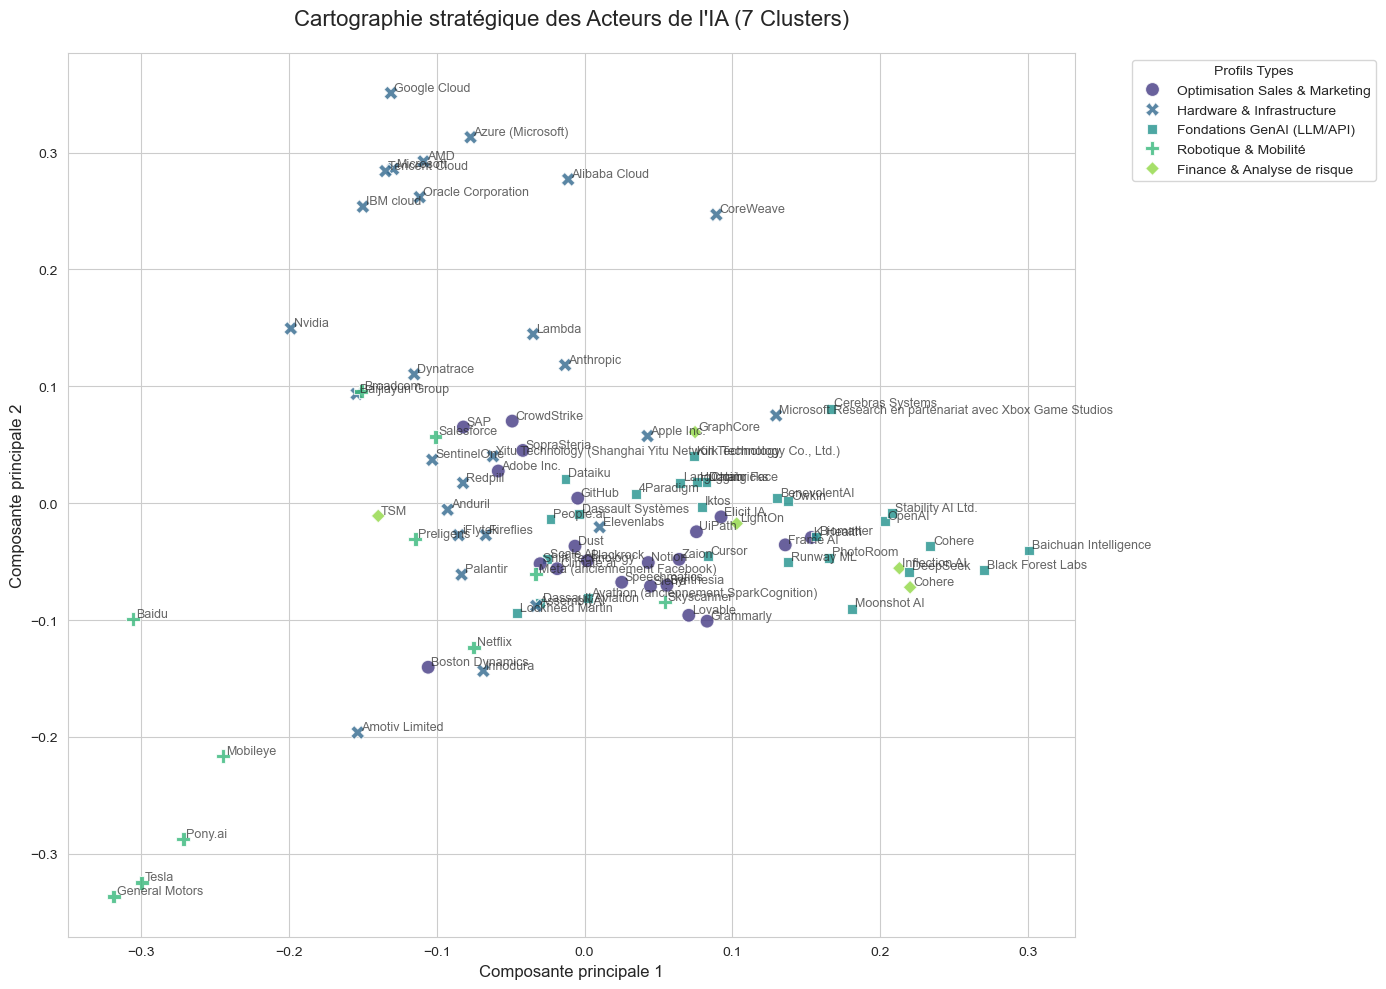

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 1. Réduction de dimension (PCA pour passer de 1000+ dimensions à 2)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X.toarray())
df['x'] = coords[:, 0]
df['y'] = coords[:, 1]

# 2. Paramétrage du style visuel
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")

# 3. Création du graphique
scatter = sns.scatterplot(
    data=df, 
    x='x', y='y', 
    hue='Profil_Type', 
    style='Profil_Type',
    palette='viridis', 
    s=100, 
    alpha=0.8
)

# 4. Ajout des noms des entreprises sur les points (optionnel, pour la clarté)
# Pour éviter de surcharger, on n'affiche que quelques noms par cluster
for i in range(df.shape[0]):
    if i % 1 == 0: # Affiche 1 nom sur 2
        plt.text(df.x[i]+0.002, df.y[i]+0.002, df["Nom de l'entreprise étudiée"][i], 
                 fontsize=9, alpha=0.7)

# 5. Habillage
plt.title("Cartographie stratégique des Acteurs de l'IA (7 Clusters)", fontsize=16, pad=20)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.legend(title="Profils Types", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()